# Trabajo 2 Grupal

### Integrantes: Pablo Riquelme, Paula Romero, Pia Saavedra y Mario Rozas

Primero, instalamos e importamos todo lo necesario.

In [ ]:
!pip install pydataset 
from pydataset import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import datasets
import copy

## Dataset a ser utilizado: (corresponde a la base de datos de un banco)
Lo cargamos y le damos un vistazo. Los datos corresponden a los registros de los clientes del banco.

In [ ]:
bank_data = pd.read_csv("BankData.csv")
display(bank_data.head(10))

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Trans_Amt,Total_Trans_Ct
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,12691.0,777,1144,42
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,8256.0,864,1291,33
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,3418.0,0,1887,20
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,3313.0,2517,1171,20
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,4716.0,0,816,28
5,713061558,Existing Customer,44,M,2,Graduate,Married,$40K - $60K,Blue,36,3,1,4010.0,1247,1088,24
6,810347208,Existing Customer,51,M,4,Unknown,Married,$120K +,Gold,46,6,1,34516.0,2264,1330,31
7,818906208,Existing Customer,32,M,0,High School,Unknown,$60K - $80K,Silver,27,2,2,29081.0,1396,1538,36
8,710930508,Existing Customer,37,M,3,Uneducated,Single,$60K - $80K,Blue,36,5,2,22352.0,2517,1350,24
9,719661558,Existing Customer,48,M,2,Graduate,Single,$80K - $120K,Blue,36,6,3,11656.0,1677,1441,32


## Parte a) Procesamiento de los datos:

In [ ]:
#Transformación logaritmica:  [Para ver mejor los graficos]

bank_data_log = pd.read_csv("BankData.csv")

bank_data_log['Customer_Age'] = np.log(bank_data_log['Customer_Age'] + 1)
bank_data_log['Months_on_book'] = np.log(bank_data_log['Months_on_book'] + 1)
bank_data_log['Credit_Limit'] = np.log(bank_data_log['Credit_Limit'] + 1)
bank_data_log['Total_Revolving_Bal'] = np.log(bank_data_log['Total_Revolving_Bal'] + 1)
bank_data_log['Total_Trans_Amt'] = np.log(bank_data_log['Total_Trans_Amt'] + 1)
bank_data_log['Total_Trans_Ct'] = np.log(bank_data_log['Total_Trans_Ct'] + 1)

bank_data_log


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Trans_Amt,Total_Trans_Ct
0,768805383,Existing Customer,3.828641,M,3,High School,Married,$60K - $80K,Blue,3.688879,5,1,9.448727,6.656727,7.043160,3.761200
1,818770008,Existing Customer,3.912023,F,5,Graduate,Single,Less than $40K,Blue,3.806662,6,1,9.018817,6.762730,7.163947,3.526361
2,713982108,Existing Customer,3.951244,M,3,Graduate,Married,$80K - $120K,Blue,3.610918,4,1,8.137103,0.000000,7.543273,3.044522
3,769911858,Existing Customer,3.713572,F,4,High School,Unknown,Less than $40K,Blue,3.555348,3,4,8.105911,7.831220,7.066467,3.044522
4,709106358,Existing Customer,3.713572,M,3,Uneducated,Married,$60K - $80K,Blue,3.091042,5,1,8.458928,0.000000,6.705639,3.367296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,3.931826,M,2,Graduate,Single,$40K - $60K,Blue,3.713572,3,2,8.295049,7.524021,9.647110,4.770685
10123,710638233,Attrited Customer,3.737670,M,2,Unknown,Divorced,$40K - $60K,Blue,3.258097,4,2,8.361241,7.690286,9.078522,4.248495
10124,716506083,Attrited Customer,3.806662,F,1,High School,Married,Less than $40K,Blue,3.610918,5,3,8.596004,0.000000,9.239122,4.110874
10125,717406983,Attrited Customer,3.433987,M,2,Graduate,Unknown,$40K - $60K,Blue,3.610918,4,3,8.572060,0.000000,9.035511,4.143135


In [ ]:
#One Hot encoding:   [Para manejar mejor las variables nominales]
#AttritionFlag, Gender, Marital Status

encoded_columns = pd.get_dummies(bank_data['Attrition_Flag'])
bank_data_ohc = bank_data.join(encoded_columns).drop('Attrition_Flag', axis=1)

encoded_columns2 = pd.get_dummies(bank_data['Gender'])
bank_data_ohc = bank_data_ohc.join(encoded_columns2).drop('Gender', axis=1)

encoded_columns3 = pd.get_dummies(bank_data['Marital_Status'])
bank_data_ohc = bank_data_ohc.join(encoded_columns3).drop('Marital_Status', axis=1)


#Ordinal Encoder:   [Para manejar mejor las variables ordinales]
#Education Level, Income_Category, Card_category
from sklearn.preprocessing import OrdinalEncoder

bank_data_oe = bank_data_ohc

encoder = OrdinalEncoder(categories=[["Unknown", "Uneducated", "High School", "College", "Graduate", "Post-Graduate", "Doctorate"]]) #Acá debe anotarse en orden
encoder.fit(bank_data_oe[["Education_Level"]])
bank_data_oe["Education_Level-encoded"] = encoder.transform(bank_data[["Education_Level"]])
bank_data_oe = bank_data_oe.drop('Education_Level', axis=1)

encoder2 = OrdinalEncoder(categories=[["Blue", "Silver","Gold", "Platinum"]]) #Acá debe anotarse en orden
encoder2.fit(bank_data_oe[["Card_Category"]])
bank_data_oe["Card_Category-encoded"] = encoder2.transform(bank_data_oe[["Card_Category"]])
bank_data_oe = bank_data_oe.drop('Card_Category', axis=1)

encoder3 = OrdinalEncoder(categories=[["Unknown", "Less than $40K","$40K - $60K", "$60K - $80K", "$80K - $120K", "$120K +"]]) #Acá debe anotarse en orden
encoder3.fit(bank_data_oe[["Income_Category"]])
bank_data_oe["Income_Category-encoded"] = encoder3.transform(bank_data_oe[["Income_Category"]])
bank_data_oe = bank_data_oe.drop('Income_Category', axis=1)

bank_data_ordtrans = bank_data_oe
display(bank_data_ordtrans)


,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Trans_Amt,Total_Trans_Ct,Attrited Customer,Existing Customer,F,M,Divorced,Married,Single,Unknown,Education_Level-encoded,Card_Category-encoded,Income_Category-encoded
0,768805383,45,3,39,5,1,12691.0,777,1144,42,0,1,0,1,0,1,0,0,2.0,0.0,3.0
1,818770008,49,5,44,6,1,8256.0,864,1291,33,0,1,1,0,0,0,1,0,4.0,0.0,1.0
2,713982108,51,3,36,4,1,3418.0,0,1887,20,0,1,0,1,0,1,0,0,4.0,0.0,4.0
3,769911858,40,4,34,3,4,3313.0,2517,1171,20,0,1,1,0,0,0,0,1,2.0,0.0,1.0
4,709106358,40,3,21,5,1,4716.0,0,816,28,0,1,0,1,0,1,0,0,1.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,2,40,3,2,4003.0,1851,15476,117,0,1,0,1,0,0,1,0,4.0,0.0,2.0
10123,710638233,41,2,25,4,2,4277.0,2186,8764,69,1,0,0,1,1,0,0,0,0.0,0.0,2.0
10124,716506083,44,1,36,5,3,5409.0,0,10291,60,1,0,1,0,0,1,0,0,2.0,0.0,1.0
10125,717406983,30,2,36,4,3,5281.0,0,8395,62,1,0,0,1,0,0,0,1,4.0,0.0,2.0


In [ ]:
#Estandarización columnas:   [Para reducir dimensión]

std_scaler = StandardScaler()
bank_data_std = std_scaler.fit_transform(bank_data_ordtrans)


#Estandarización con trans. log.
bank_data_log2 = bank_data_ordtrans

bank_data_log2['Customer_Age'] = np.log(bank_data_log2['Customer_Age'] + 1)
bank_data_log2['Months_on_book'] = np.log(bank_data_log2['Months_on_book'] + 1)
bank_data_log2['Credit_Limit'] = np.log(bank_data_log2['Credit_Limit'] + 1)
bank_data_log2['Total_Revolving_Bal'] = np.log(bank_data_log2['Total_Revolving_Bal'] + 1)
bank_data_log2['Total_Trans_Amt'] = np.log(bank_data_log2['Total_Trans_Amt'] + 1)
bank_data_log2['Total_Trans_Ct'] = np.log(bank_data_log2['Total_Trans_Ct'] + 1)

std_scaler2 = StandardScaler()
bank_data_std2 = std_scaler2.fit_transform(bank_data_log2)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.802878,-0.049868,0.503368,0.455229,0.763943,-1.327136,0.935158,0.518047,-1.825513,-0.815598,-0.437506,0.437506,-1.059956,1.059956,-0.282405,1.077338,-0.798507,-0.282609,-0.354022,-0.250587,0.620039
1,2.156861,0.412999,2.043199,0.905294,1.407306,-1.327136,0.503525,0.527317,-1.607848,-1.446099,-0.437506,0.437506,0.943436,-0.943436,-0.282405,-0.928214,1.252337,-0.282609,0.822218,-0.250587,-0.736292
2,-0.682769,0.626971,0.503368,0.148575,0.120579,-1.327136,-0.462396,-1.759873,-0.951036,-2.895944,-0.437506,0.437506,-1.059956,1.059956,-0.282405,1.077338,-0.798507,-0.282609,0.822218,-0.250587,1.298204
3,0.832862,-0.707190,1.273283,-0.074455,-0.522785,1.641478,-0.498783,0.612290,-1.783177,-2.895944,-0.437506,0.437506,0.943436,-0.943436,-0.282405,-0.928214,-0.798507,3.538459,-0.354022,-0.250587,-0.736292
4,-0.814896,-0.707190,0.503368,-2.100223,0.763943,-1.327136,-0.096230,-1.759873,-2.457442,-1.899744,-0.437506,0.437506,-1.059956,1.059956,-0.282405,1.077338,-0.798507,-0.282609,-0.942142,-0.250587,0.620039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0.899389,0.521329,-0.266547,0.550878,-0.522785,-0.337598,-0.280614,0.589310,2.103931,1.472674,-0.437506,0.437506,-1.059956,1.059956,-0.282405,-0.928214,1.252337,-0.282609,0.822218,-0.250587,-0.058127
10123,-0.773384,-0.567700,-0.266547,-1.335669,0.120579,-0.337598,-0.205632,0.601880,1.361449,0.364660,2.285681,-2.285681,-1.059956,1.059956,3.541013,-0.928214,-0.798507,-0.282609,-1.530263,-0.250587,-0.058127
10124,-0.614372,-0.173728,-1.036462,0.148575,0.763943,0.651940,0.054816,-1.759873,1.576583,0.047166,2.285681,-2.285681,0.943436,-0.943436,-0.282405,1.077338,-0.798507,-0.282609,-0.354022,-0.250587,-0.736292
10125,-0.589958,-2.401896,-0.266547,0.148575,0.120579,0.651940,0.028635,-1.759873,1.303074,0.122641,2.285681,-2.285681,-1.059956,1.059956,-0.282405,-0.928214,-0.798507,3.538459,0.822218,-0.250587,-0.058127


In [ ]:
#Normalización columnas: https://chrisalbon.com/code/python/data_wrangling/pandas_normalize_column/
from sklearn import preprocessing
# Set charts to view inline
%matplotlib inline

bank_data_norm = bank_data
lista = ['Customer_Age', 'Months_on_book', 'Credit_Limit', 'Total_Revolving_Bal', 'Total_Trans_Amt', 'Total_Trans_Ct']

for i in lista:
  x = bank_data_norm[[i]].values.astype(float)
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  df_normalized = pd.DataFrame(x_scaled)
  name = i + '_Norm'
  df_normalized = df_normalized.rename({0: name,}, axis=1)
  bank_data_norm = bank_data_norm.join(df_normalized).drop(i, axis=1)

bank_data_norm

,CLIENTNUM,Attrition_Flag,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Total_Relationship_Count,Months_Inactive_12_mon,Customer_Age_Norm,Months_on_book_Norm,Credit_Limit_Norm,Total_Revolving_Bal_Norm,Total_Trans_Amt_Norm,Total_Trans_Ct_Norm
0,768805383,Existing Customer,M,3,High School,Married,$60K - $80K,Blue,5,1,0.404255,0.604651,0.340190,0.308701,0.035273,0.248062
1,818770008,Existing Customer,F,5,Graduate,Single,Less than $40K,Blue,6,1,0.489362,0.720930,0.206112,0.343266,0.043452,0.178295
2,713982108,Existing Customer,M,3,Graduate,Married,$80K - $120K,Blue,4,1,0.531915,0.534884,0.059850,0.000000,0.076611,0.077519
3,769911858,Existing Customer,F,4,High School,Unknown,Less than $40K,Blue,3,4,0.297872,0.488372,0.056676,1.000000,0.036775,0.077519
4,709106358,Existing Customer,M,3,Uneducated,Married,$60K - $80K,Blue,5,1,0.297872,0.186047,0.099091,0.000000,0.017025,0.139535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,M,2,Graduate,Single,$40K - $60K,Blue,3,2,0.510638,0.627907,0.077536,0.735399,0.832647,0.829457
10123,710638233,Attrited Customer,M,2,Unknown,Divorced,$40K - $60K,Blue,4,2,0.319149,0.279070,0.085819,0.868494,0.459219,0.457364
10124,716506083,Attrited Customer,F,1,High School,Married,Less than $40K,Blue,5,3,0.382979,0.534884,0.120042,0.000000,0.544175,0.387597
10125,717406983,Attrited Customer,M,2,Graduate,Unknown,$40K - $60K,Blue,4,3,0.085106,0.534884,0.116172,0.000000,0.438689,0.403101


## Parte b) Proceso de selección de variables:

En base a lo hecho en la entrega anterior, hemos decidido seleccionar las siguientes columnas de datos, ya que estimamos que son las más utiles y prometedoras, a continuación se ahonda en la explicación.

### Total_Trans_Amt y Total_trans_Ct

Ambas columnas fueron elegidas ya que se puede ver una estrecha relación entre ellas con el abandono de clientes, como se puede ver en el siguiente gráfico. 

Cada variable por si sola contiene una buena cantidad de información que permite distinguir ciertos comportamientos, por lo que en base a que en un futuro se debe hacer un modelo que aprenda y permita identificar a un posible cliente que se vaya del banco, decidimos que era necesario incluir estas variables, que juntas y por si solas aportan una buena fuente de información para el modelo.

Text(0.5, 1.0, 'Gráfico de dispersión Monto vs Cantidad de transacción (Clientes que abandonan y los que no)')

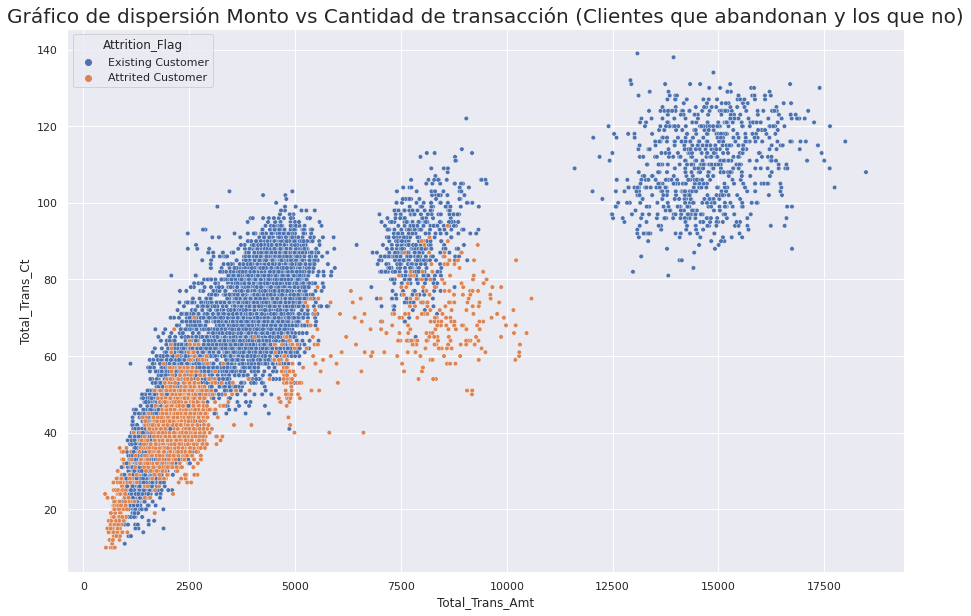

In [ ]:
# Total_Trans_Amt y Total_Trans_Ct
tam2 = sns.set(rc = {'figure.figsize':(15,10)})
ax2 = sns.scatterplot(x="Total_Trans_Amt", y="Total_Trans_Ct", hue="Attrition_Flag", data=bank_data, s = 20, alpha = 1).set_title('Gráfico de dispersión Monto vs Cantidad de transacción (Clientes que abandonan y los que no)', fontsize = 20)
display(ax2)

### Dependent_count

Elegimos esta columna de datos dado que se puede ver una cierta tendencia en esta, en el siguiente gráfico donde se ve el porcentaje de abandono de los clientes por número de producto que posee en el banco, se aprecia una ligera tendencia, que mientras menos productos tiene un cliente, más probabilidad hay de que abandonde el banco.

En base a la creación del modelo, a pesar de que quizas su aporte no sea tan grande como lo anterior, estimamos conveniente considerar esta columna.

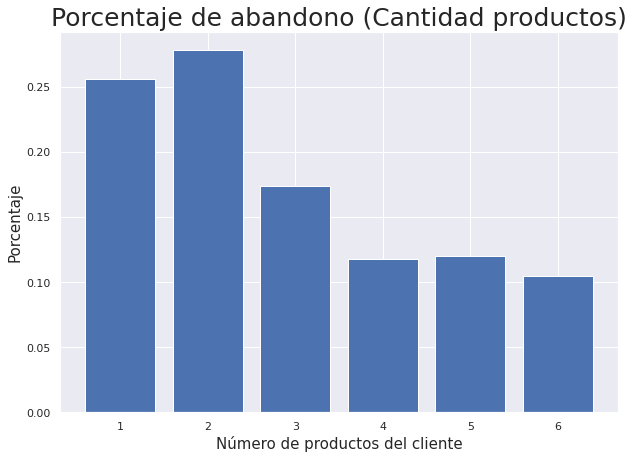

In [ ]:
#Clientes que abandonan por número de productos

data = bank_data
data = data.loc[data["Attrition_Flag"] == 'Attrited Customer']
data2 = bank_data
data2 = data2.loc[data2["Attrition_Flag"] == 'Existing Customer']

q = data.groupby('Total_Relationship_Count').size()
q = q.to_frame()
q = q.rename(columns={0: 'Cantidad'})

#Clientes que se mantienen
w = data2.groupby('Total_Relationship_Count').size()
w = w.to_frame()
w = w.rename(columns={0: 'Cantidad'})

#Se hace la unión
products = pd.merge(w, q, on= 'Total_Relationship_Count')
products = products.rename(columns={'Cantidad_x': 'Sigue'})
products = products.rename(columns={'Cantidad_y': 'Abandonó'})

#Para ver el porcentaje de abandono
por_pro_abandono = products['Abandonó']/(products['Abandonó']+products['Sigue'])
por_pro_abandono = por_pro_abandono.to_frame()
por_pro_abandono = por_pro_abandono.rename(columns={0: 'Porcentaje abandono'})

products = pd.merge(products, por_pro_abandono, on= 'Total_Relationship_Count')

#Graficar
prod = [1,2,3,4,5,6]
size10 = plt.figure(figsize=(10, 7))
tit10 = plt.title("Porcentaje de abandono (Cantidad productos)", size=25)
xtit10 = plt.xlabel("Número de productos del cliente", size=15)
ytit10 = plt.ylabel("Porcentaje", size=15)
d16 = plt.bar(prod, products['Porcentaje abandono'])
plt.show()

### Credit_Limit y Total_Revolving_Bal

Elegimos estas columnas debido a que tambien se puede ver una clara tendencia de que mientras menos valor se tenga de una o la otra, más probable es de que el cliente haya abandonado. Esto se ve en los siguientes 2 gráficos.

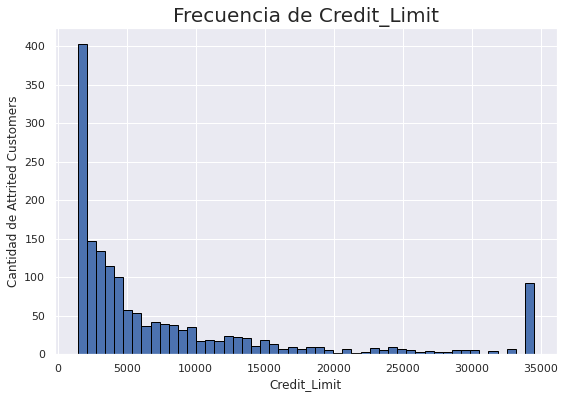

In [ ]:
#Attrited customers Credit limit
#histograma
datos = data.loc[data["Attrition_Flag"] == 'Attrited Customer']
plt.figure(figsize=(9, 6))
plt.title("Frecuencia de Credit_Limit", size=20)
plt.xlabel("Credit_Limit", size=12)
plt.ylabel("Cantidad de Attrited Customers", size=12)
hits_credit=plt.hist(datos["Credit_Limit"], bins=50, ec="black") 
plt.show()

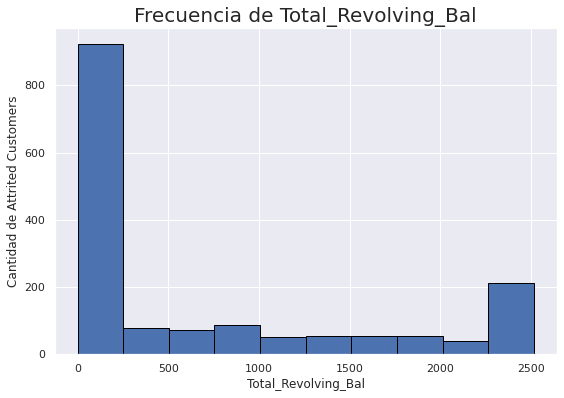

In [ ]:
datos = data.loc[data["Attrition_Flag"] == 'Attrited Customer']
plt.figure(figsize=(9, 6))
plt.title("Frecuencia de Total_Revolving_Bal", size=20)
plt.xlabel("Total_Revolving_Bal", size=12)
plt.ylabel("Cantidad de Attrited Customers", size=12)
hits_credit=plt.hist(datos["Total_Revolving_Bal"], bins=10, ec="black") 
plt.show()

Esto se confirma cuando se ve la relación entre estas 2 variables, ya que se ve que cuando cualquiera de los ejes toma un valor pequeño, mayor es la probabilidad de encontrar clientes que abandonan. Esto estimamos que sirve para el modelo futuro.

Text(0.5, 1.0, 'Gráfico de dispersión limite de credito vs cupo no pagado (clientes que abandonan y que no)')

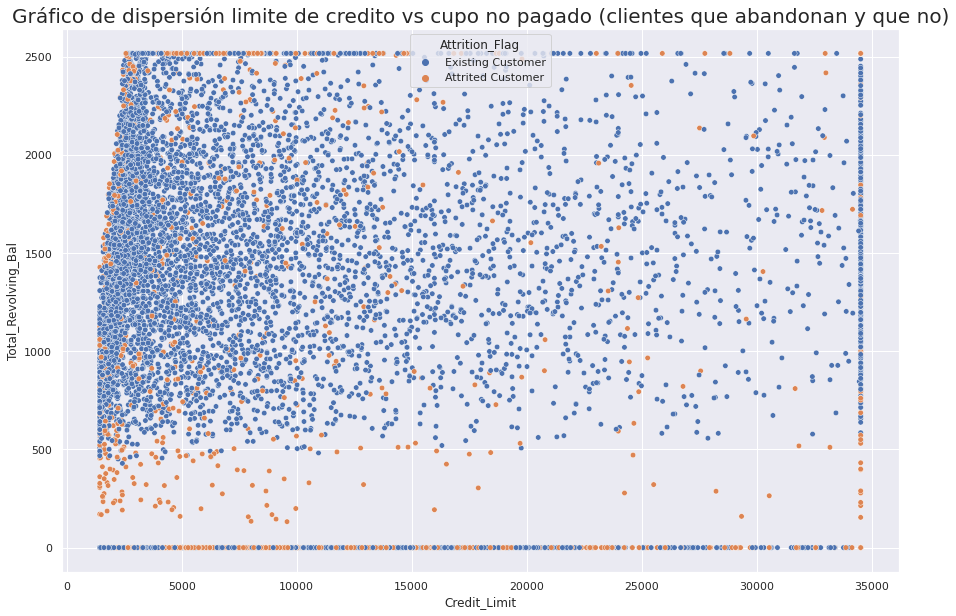

In [ ]:
tam3 = sns.set(rc = {'figure.figsize':(15,10)})
ax3 = sns.scatterplot(x="Credit_Limit", y="Total_Revolving_Bal", hue="Attrition_Flag", data=bank_data, s = 30, alpha = 1).set_title('Gráfico de dispersión limite de credito vs cupo no pagado (clientes que abandonan y que no)', fontsize= 20)
display(ax3)

###Months_on_book y Months_inactive

Estas 2 variables fueron elegidas debido a que, si bien no hay una relación tan estrecha entre estas y el abandono de clientes, aún así en el siguiente gráfico se puede apreciar la relación entre ambas variables y el abandono. (Por columna del gráfico, se puede ver pequeños clusters de clientes que han abandonado). Con el modelo en mente, se determina que estas variables son un aporte.

Text(0.5, 1.0, 'Gráfico de dispersión meses inactivos vs meses de estancia (Clientes que han abandonado y que no)')

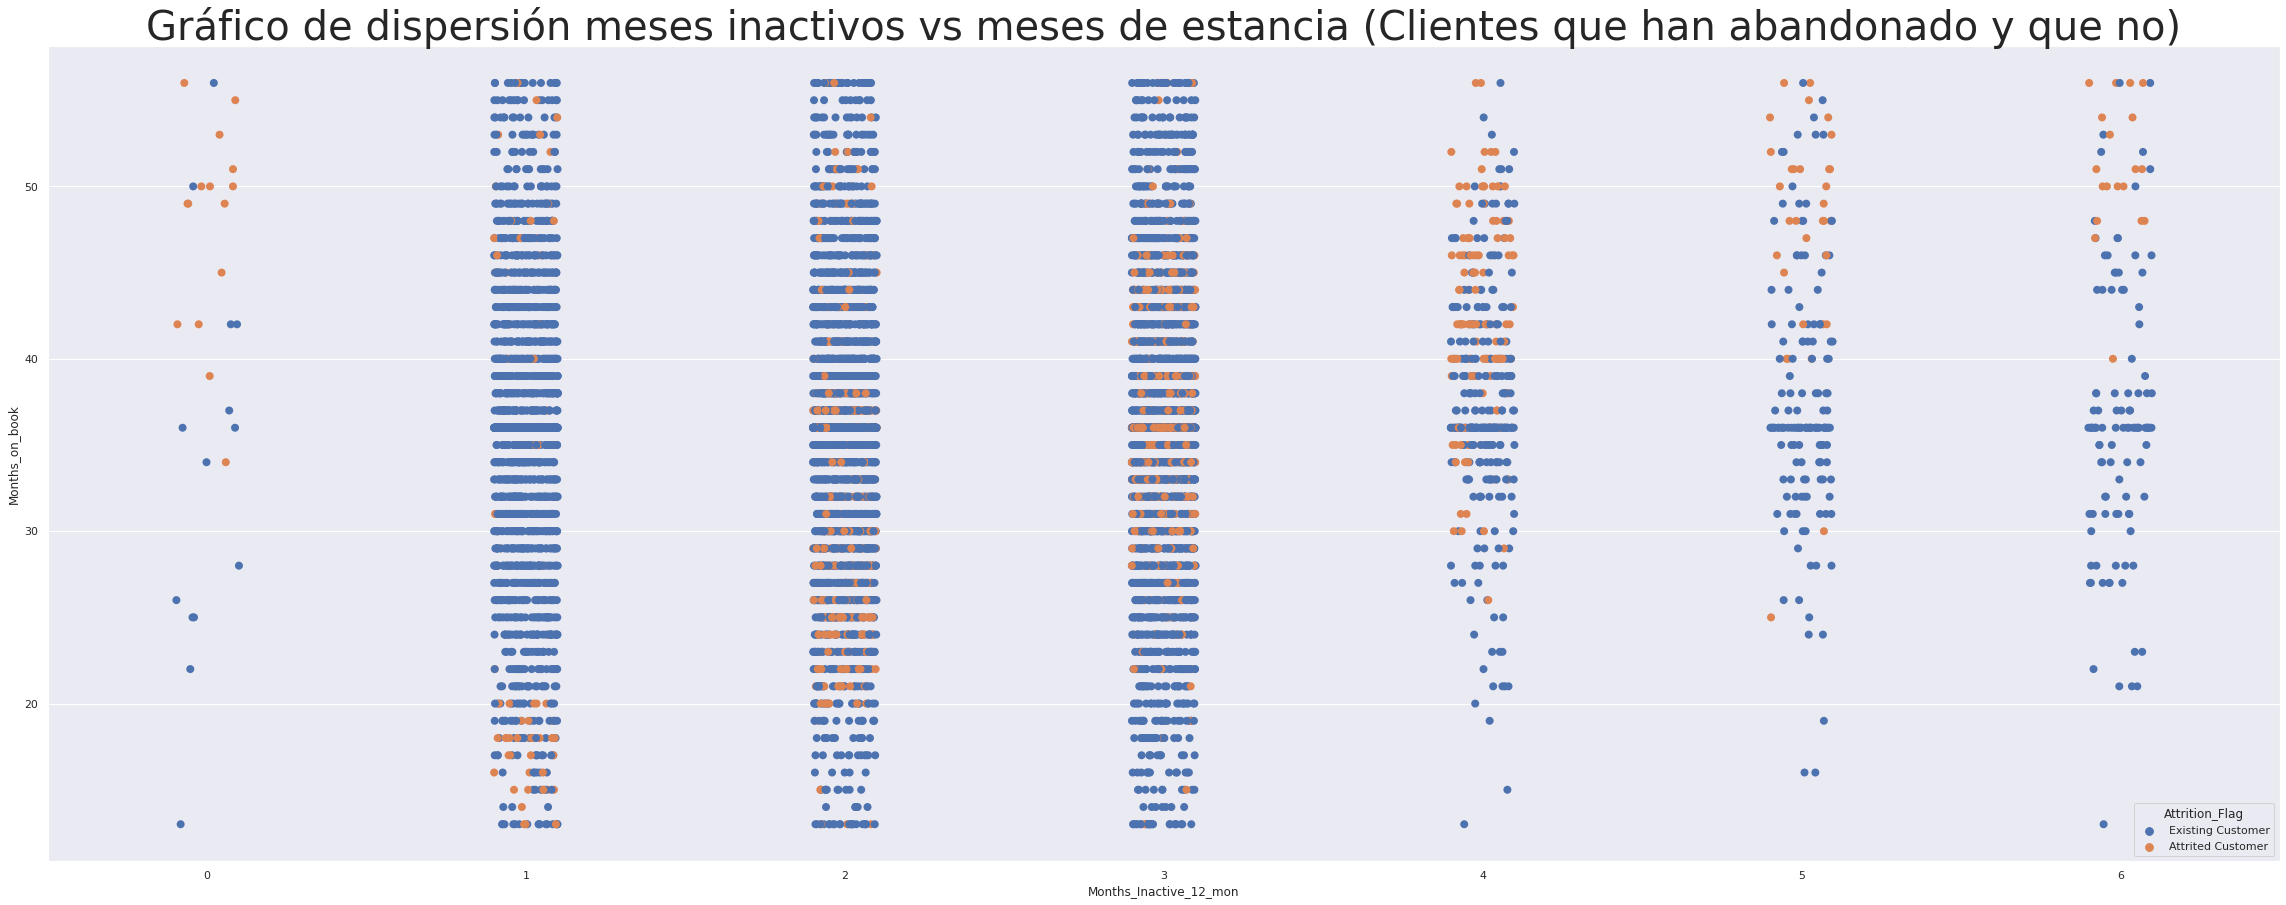

In [ ]:
#Se hace el grafico
tam = sns.set(rc = {'figure.figsize':(40,15)})
ax = sns.stripplot(x="Months_Inactive_12_mon", y="Months_on_book", hue="Attrition_Flag", data=bank_data, size = 8, alpha = 1).set_title('Gráfico de dispersión meses inactivos vs meses de estancia (Clientes que han abandonado y que no)', fontsize =40)
display(ax)

In [ ]:
#Edad, card category, educacion, dependent count, income category, marital status, gender no.

#Se explica en el pdf

(((((((bank_data.drop("Customer_Age", axis =1)).drop("Card_Category", axis =1).drop("Education_Level", axis =1)).drop("Dependent_count", axis =1).drop("Income_Category", axis =1)))).drop("Gender", axis =1)).drop("Marital_Status", axis =1))


,CLIENTNUM,Attrition_Flag,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Trans_Amt,Total_Trans_Ct
0,768805383,Existing Customer,39,5,1,12691.0,777,1144,42
1,818770008,Existing Customer,44,6,1,8256.0,864,1291,33
2,713982108,Existing Customer,36,4,1,3418.0,0,1887,20
3,769911858,Existing Customer,34,3,4,3313.0,2517,1171,20
4,709106358,Existing Customer,21,5,1,4716.0,0,816,28
...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,40,3,2,4003.0,1851,15476,117
10123,710638233,Attrited Customer,25,4,2,4277.0,2186,8764,69
10124,716506083,Attrited Customer,36,5,3,5409.0,0,10291,60
10125,717406983,Attrited Customer,36,4,3,5281.0,0,8395,62
